In [1]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI,OpenAIEmbeddings #this to above classes we used to interact with llm model.
from dotenv import load_dotenv
from langgraph.graph import StateGraph,END,START #this class we used to build stateful workflows in graphical form mei.
from pydantic import BaseModel,Field,computed_field
from typing import Annotated,List,Dict,TypedDict,Optional
from langchain_core.output_parsers import PydanticOutputParser,StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from typing import Literal,Optional
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from langgraph.graph.message import BaseMessage #this parent class of all message class.
import operator
from langchain.utilities import SerpAPIWrapper #using this class we performing search operation

#To save state memory or intermediate level shared Memory throughout the workflow in Database 
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
import requests
import random

from langsmith import traceable

#initializing the project name which can be seen in Langsmith website.
import os
os.environ['LANGCHAIN_PROJECT'] = "CHATBOT USING TOOL MONITORING"


In [2]:
#loading all the environment file.
load_dotenv()


#openAI model object.
model1 = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")

from langchain_core.tools import tool

In [3]:
api_key = os.getenv("SERPAPI_API_KEY")

In [4]:

from langchain.agents import  Tool


# Google search tool
from langchain.utilities import SerpAPIWrapper
api_key = os.getenv("SERPAPI_API_KEY")
search = SerpAPIWrapper(serpapi_api_key=api_key)

search_tool = Tool(
    name="GoogleSearch",
    func=search.run,
    description="Search the web to answer questions"
)

# Calculator tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    try:
        if operation == "add": result = first_num + second_num
        elif operation == "sub": result = first_num - second_num
        elif operation == "mul": result = first_num * second_num
        elif operation == "div": result = first_num / second_num if second_num != 0 else "Division by zero"
        else: return {"error": f"Unsupported operation {operation}"}
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

calc_tool = Tool(
    name="Calculator",
    func=calculator,
    description="Perform basic arithmetic: add, sub, mul, div"
)

# Stock price tool
import requests
def get_stock_price(symbol: str) -> dict:
    url = f'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=1PPNPDOMK62HNKRO'
    return requests.get(url).json()

stock_tool = Tool(
    name="StockPrice",
    func=get_stock_price,
    description="Fetch latest stock price for a given symbol"
)



In [5]:
#lst of tool object
tools = [search_tool,calc_tool,stock_tool] 
tools


[Tool(name='GoogleSearch', description='Search the web to answer questions', func=<bound method SerpAPIWrapper.run of SerpAPIWrapper(search_engine=<class 'serpapi.google_search.GoogleSearch'>, params={'engine': 'google', 'google_domain': 'google.com', 'gl': 'us', 'hl': 'en'}, serpapi_api_key='2a51db69f30b5e46589cd89d12929fc47fa8f2fcf2609210d953ac20cc6c3a0b', aiosession=None)>),
 Tool(name='Calculator', description='Perform basic arithmetic: add, sub, mul, div', func=<function calculator at 0x0000021437688CA0>),
 Tool(name='StockPrice', description='Fetch latest stock price for a given symbol', func=<function get_stock_price at 0x000002143BBA3880>)]

In [6]:
#binding the chatmodel with tool
llm_with_tools = model1.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000214377F59C0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002143BB87BB0>, root_client=<openai.OpenAI object at 0x00000214377F4070>, root_async_client=<openai.AsyncOpenAI object at 0x000002143BB87B20>, temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'GoogleSearch', 'description': 'Search the web to answer questions', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'Calculator', 'description': 'Perform basic arithmetic: add, sub, mul, div', 'parameters': {'properties': {'__arg1': {'title': '__arg1', 'type': 'string'}}, 'required': ['__arg1'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'StockPrice', 'descr

In [7]:
#defining state schema for chatbot.
from langgraph.graph.message import add_messages
class ChatbotState(TypedDict):
    message : Annotated[list[BaseMessage], add_messages] 


In [8]:
#creating a graph object by using stategraph class.
graph = StateGraph(ChatbotState)
graph

In [9]:
def chat_node(state: ChatbotState):
    messages = state["message"]
    print("Messages received:", messages)
    response = llm_with_tools.invoke(messages)  # or {"message": messages}
    print("Response:", response)
    return {"message": messages + [AIMessage(content=response)]}

In [10]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

In [11]:
# ✅ Tool condition logic
def tools_condition(state: ChatbotState, tool_name: str) -> bool:
    messages = state["message"]
    last_message = messages[-1].content.lower()
    print(last_message)
    
    if tool_name == "GoogleSearch":
        return "search" in last_message or "find" in last_message or "google" in last_message
    elif tool_name == "Calculator":
        return any(op in last_message for op in ["add", "subtract", "multiply", "divide"])
    elif tool_name == "StockPrice":
        return "stock" in last_message and "price" in last_message
    else:
        return False

In [12]:
#graph mei nodes or edges add karne se phele mujhe ek memorysaver object banana padegha.
graph.add_node(node="chat_node",action=chat_node)
graph.add_node(node="tools",action=tool_node)


In [13]:
from langgraph.prebuilt import tools_condition #based on tool condition either map to ends node or tool node

In [14]:
#now adding the edges to graph.
graph.add_edge(START,"chat_node")
graph.add_conditional_edges('chat_node',tools_condition)


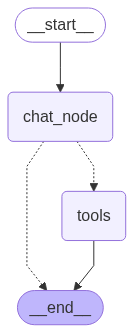

In [15]:
chatbot = graph.compile()
chatbot
